In [82]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Keras neural network model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical, plot_model
from keras import optimizers, regularizers, initializers
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization

# Scikit-sklearn preprocessing modules
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,\
                            classification_report, recall_score

# Matplotlib and plotly modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 14
    }

plt.rc('font', **font)
plt.rc('text', usetex=True)

In [3]:
df_total = pd.read_csv("data/total_300.csv")

In [4]:
df_total.columns

Index(['velocity:0', 'velocity:1', 'force:0', 'force:1',
       'total displacement:0', 'total displacement:1', 'temperature',
       'temp_power', 'temp_pressure', 'temp_density', 'node number',
       'plastic strain', 'plastic strain-rate', 'strain-rate II log10',
       'strain-rate XX', 'elastic_strain XX', 'strain-rate ZZ',
       'elastic_strain ZZ', 'strain-rate XZ', 'elastic_strain XZ', 'strain I',
       'strain II', 'strain XX', 'strain ZZ', 'strain XZ', 'stress I',
       'stress II', 'stress XX', 'stress ZZ', 'stress XZ', 'density',
       'thermal_stress', 'energy_total_vol_dev', 'energy_volumetric',
       'energy_deviatoric', 'energy_thermal', 'energy_elastic', 'coordinate:0',
       'coordinate:1'],
      dtype='object')

In [5]:
df_total = df_total.drop_duplicates()

In [6]:
threshold = 0.15
df_total['plastic strain'] = np.where(df_total['plastic strain'] > threshold, 1,0)

In [76]:
label_count = df_total.groupby(df_total['plastic strain'], as_index = False).count()

In [79]:
label_count.head()

,plastic strain,velocity:0,velocity:1,force:0,force:1,total displacement:0,total displacement:1,temperature,temp_power,temp_pressure,...,stress XZ,density,thermal_stress,energy_total_vol_dev,energy_volumetric,energy_deviatoric,energy_thermal,energy_elastic,coordinate:0,coordinate:1
0,0,824099,824099,824099,824099,824099,824099,824099,824099,824099,...,824099,824099,824099,824099,824099,824099,824099,824099,824099,824099
1,1,784160,784160,784160,784160,784160,784160,784160,784160,784160,...,784160,784160,784160,784160,784160,784160,784160,784160,784160,784160


In [80]:
class_name = list(label_count['plastic strain'])
count = list(label_count['velocity:0'])

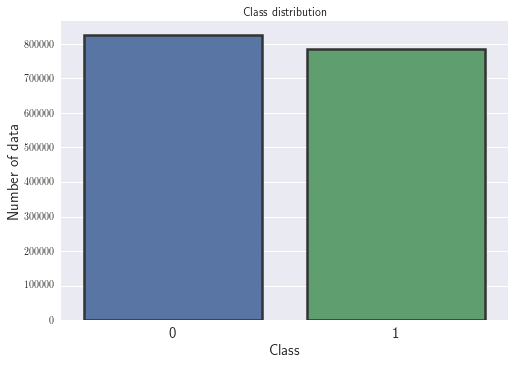

In [83]:
index = np.arange(len(class_name))
# plt.bar(class_name, count)
sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

In [84]:
feature_cols = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']

dropped_cols = ['plastic strain', 'plastic strain-rate', 'strain-rate II log10', 'strain-rate XX',
       'elastic_strain XX', 'strain-rate ZZ', 'elastic_strain ZZ',
       'strain-rate XZ', 'elastic_strain XZ', 'strain I', 'strain II',
       'strain XX', 'strain ZZ', 'strain XZ', 'coordinate:0', 'coordinate:1', 'force:0', 'force:1', 
       'total displacement:0', 'total displacement:1', 'stress I', 'stress II', 'energy_volumetric', 
       'energy_deviatoric','energy_thermal', 'energy_elastic', 'thermal_stress',
       'energy_total_vol_dev', 'temp_power', 'temp_pressure', 'temp_density', 'node number']

In [85]:
def scale_feature(features):    
    mms = StandardScaler()
    scaled_features = mms.fit_transform(features)
    return scaled_features, mms

## Neural network model

In [16]:
class build_neural_network:
    
    def __init__(self, model_name, xtrain, ytrain, xval, yval):
        self.model_name = model_name
        self.xtrain = xtrain
        self.ytrain = to_categorical(ytrain)
        self.xval = xval
        self.yval = to_categorical(yval)
        self.input_shape = np.shape(xtrain)[1]
        self.output_shape = np.shape(self.ytrain)[1]
        self.model = None
        self.ypred = None
        self.weight_path = "./weights/"
            
    def get_model_weights(self):
        return self.model.get_weights()

    def create_model(self):
        self.model = Sequential()
        self.model.add(Dense(self.input_shape, 
                             kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed = 2018), 
                             activation = 'relu', name='layer_1',
                             input_shape = (self.input_shape,)))
        
        self.model.add(Dense(12, activation = 'relu', name='layer_2'))
            
        self.model.add(Dense(self.output_shape, activation="softmax", name='Output_layer'))
        self.model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()
    
    def train_model(self, training_epochs):
        self.create_model()
        
        filepath = self.weight_path + str(self.model_name) + '.hdf5'
        
        if not os.path.exists(self.weight_path):
            os.makedirs(self.weight_path)
        
        checkpoint = ModelCheckpoint(filepath, verbose=0, period = training_epochs)
        self.model.fit(self.xtrain, self.ytrain, batch_size = 10, epochs = training_epochs, 
        callbacks = [checkpoint], validation_data=(self.xval, self.yval))
        
        self.save_model()
        
    def save_model(self):
        file_name = str(self.weight_path) + str(self.model_name)
        self.model.save(file_name)
    
    def predict(self, xtest):
        self.ypred = self.model.predict(xtest)
        
    def classification_report(self, xtest, ytest):
        self.predict(xtest)
        Y_test_class = np.argmax(ytest, axis = 1)
        Y_pred_class = np.argmax(self.ypred, axis = 1)
        
        print('Accuracy: {}'.format(accuracy_score(Y_test_class, Y_pred_class)))
        print('Classification report: \n {} \n'.format(classification_report(Y_test_class, Y_pred_class)))
        print('Confusion matrix: {}'.format(confusion_matrix(Y_test_class, Y_pred_class)))
    
    def set_color_bar(self, a, fig, cbar_min, cbar_max):
        fig.subplots_adjust(hspace=0.5)
        tick_v = np.linspace(cbar_min, cbar_max, 20, endpoint=True)
        fig.colorbar(a, orientation='vertical', ticks = tick_v)
    
    def plot_model_weights(self, figsize):    
        model_weights = []
        weights = self.get_model_weights()
        layer_1_weights = weights[0]
        layer_2_weights = weights[4]    
        cbar_max = np.amax([np.amax(layer_1_weights), np.amax(layer_2_weights)])
        cbar_min = np.amin([np.amin(layer_1_weights), np.amin(layer_2_weights)])
        
        # Layer-1
        fig = plt.figure(figsize= figsize)
        plt.subplot(1,2, 1)
        mesh_plot = plt.pcolormesh(np.transpose(weights[0]), clim=(cbar_min, cbar_max))
        labels = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']
        plt.xticks([0.5+float(x) for x in range(0, len(labels))], labels, rotation='vertical')
        plt.yticks([0.5+float(x) for x in range(0, len(labels))], list(range(1,13)))
        plt.ylabel('Hidden Units')
        
        # Output layer
        plt.subplot(1, 2, 2)
        bb = np.reshape(weights[1], (self.input_shape, 1))
        mesh_plot = plt.pcolormesh(bb, clim=(cbar_min, cbar_max))
        plt.xticks([0.5],['Output Unit'],rotation='vertical')
        plt.yticks([0.5+float(x) for x in range(0, len(labels))], list(range(1,13)))
        self.set_color_bar(mesh_plot, fig, cbar_min, cbar_max)

        plt.tight_layout()
        plt.show()


In [86]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = 2018).split(X, y))

        train_proba = np.zeros((X.shape[0], no_class))
        test_proba = np.zeros((T.shape[0], no_class))
        
        
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = to_categorical(y[train_idx])
                X_valid = X[valid_idx]
                Y_valid = to_categorical(y[valid_idx])
                
                clf.fit(x = X_train, y = Y_train, batch_size = 64, epochs = 2, class_weight = None)
                
                valid_proba = clf.predict(X_valid)
                train_proba[valid_idx, :] = valid_proba
                test_proba  += clf.predict(T)
                
            test_proba /= self.n_splits
            
        return train_proba, test_proba

In [87]:
def create_model(input_shape):
    
    model = Sequential()
    model.add(Dense(input_shape, 
                             kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed = 2018), 
                             activation = 'relu', name='layer_1',
                             input_shape = (input_shape,)))
    model.add(Dense(12, activation = 'relu', name = 'layer_2'))
    model.add(Dense(2, activation="softmax", name = 'Output_layer'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [71]:
ytrain = df_total['plastic strain']
xtrain, mms = scale_feature(df_total[feature_cols])

input_shape = np.shape(xtrain)[1] 

In [72]:
model = create_model(input_shape)
base_models = [model]  
plot_model(model, to_file='model.png')

In [73]:
val = 350
file_name = "new_data/totoal."+ str(val) +".csv"
df_test = pd.read_csv(file_name)
df_test = df_test.drop_duplicates()
df_test['plastic strain'] = np.where(df_test['plastic strain'] > threshold, 1,0)
xtest = df_test[feature_cols]
ytest = df_test['plastic strain']
xtest = mms.fit_transform(xtest)

In [74]:
stack = Create_ensemble(n_splits = 2, base_models = base_models) 
train_proba, test_proba = stack.predict(xtrain, ytrain, xtest)

Epoch 1/2
804129/804129 [==============================] - ETA: 0s - loss: 0.0631 - acc: 0.979 - 43s - loss: 0.0631 - acc: 0.9795    
Epoch 2/2
804129/804129 [==============================] - 45s - loss: 0.0453 - acc: 0.9841    
Epoch 1/2
804130/804130 [==============================] - 43s - loss: 0.0436 - acc: 0.9842    
Epoch 2/2
804130/804130 [==============================] - 43s - loss: 0.0426 - acc: 0.9844    


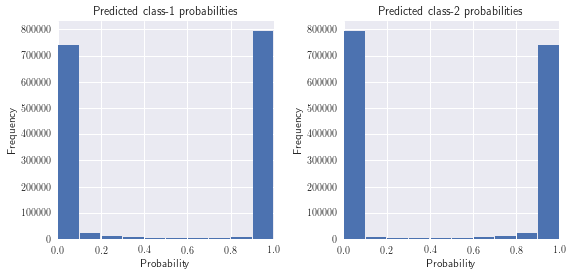

In [92]:
# histogram of predicted probabilities
plt.figure(figsize=(12, 4))
nclasses = 2
for i in range(nclasses):
    
    plt.subplot(1, 3, i+1)
    plt.hist(train_proba[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i+1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [112]:
def repredict(y_pred):
    length = (y_pred.shape)[0]
    newpred = []
    for i in range(length):
        if y_pred[i, 1] >= 0.75:
            newpred.append(1)
        else:
            newpred.append(0)
    return newpred

In [113]:
newpred_train = repredict(train_proba)

In [114]:
print('1. The F-1 score of the model {}\n'.format(f1_score(ytrain, newpred_train, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(ytrain, newpred_train, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(ytrain, newpred_train)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(ytrain, newpred_train)))

1. The F-1 score of the model 0.9802617841341253

2. The recall score of the model 0.9800841622741132

3. Classification report 
              precision    recall  f1-score   support

          0       0.97      0.99      0.98    824099
          1       0.99      0.97      0.98    784160

avg / total       0.98      0.98      0.98   1608259
 

4. Confusion matrix 
 [[814265   9834]
 [ 21877 762283]] 



In [115]:
newpred_test = repredict(test_proba)

In [108]:
len(newpred_test)
# len(ytest)

8700

## Test data preparation

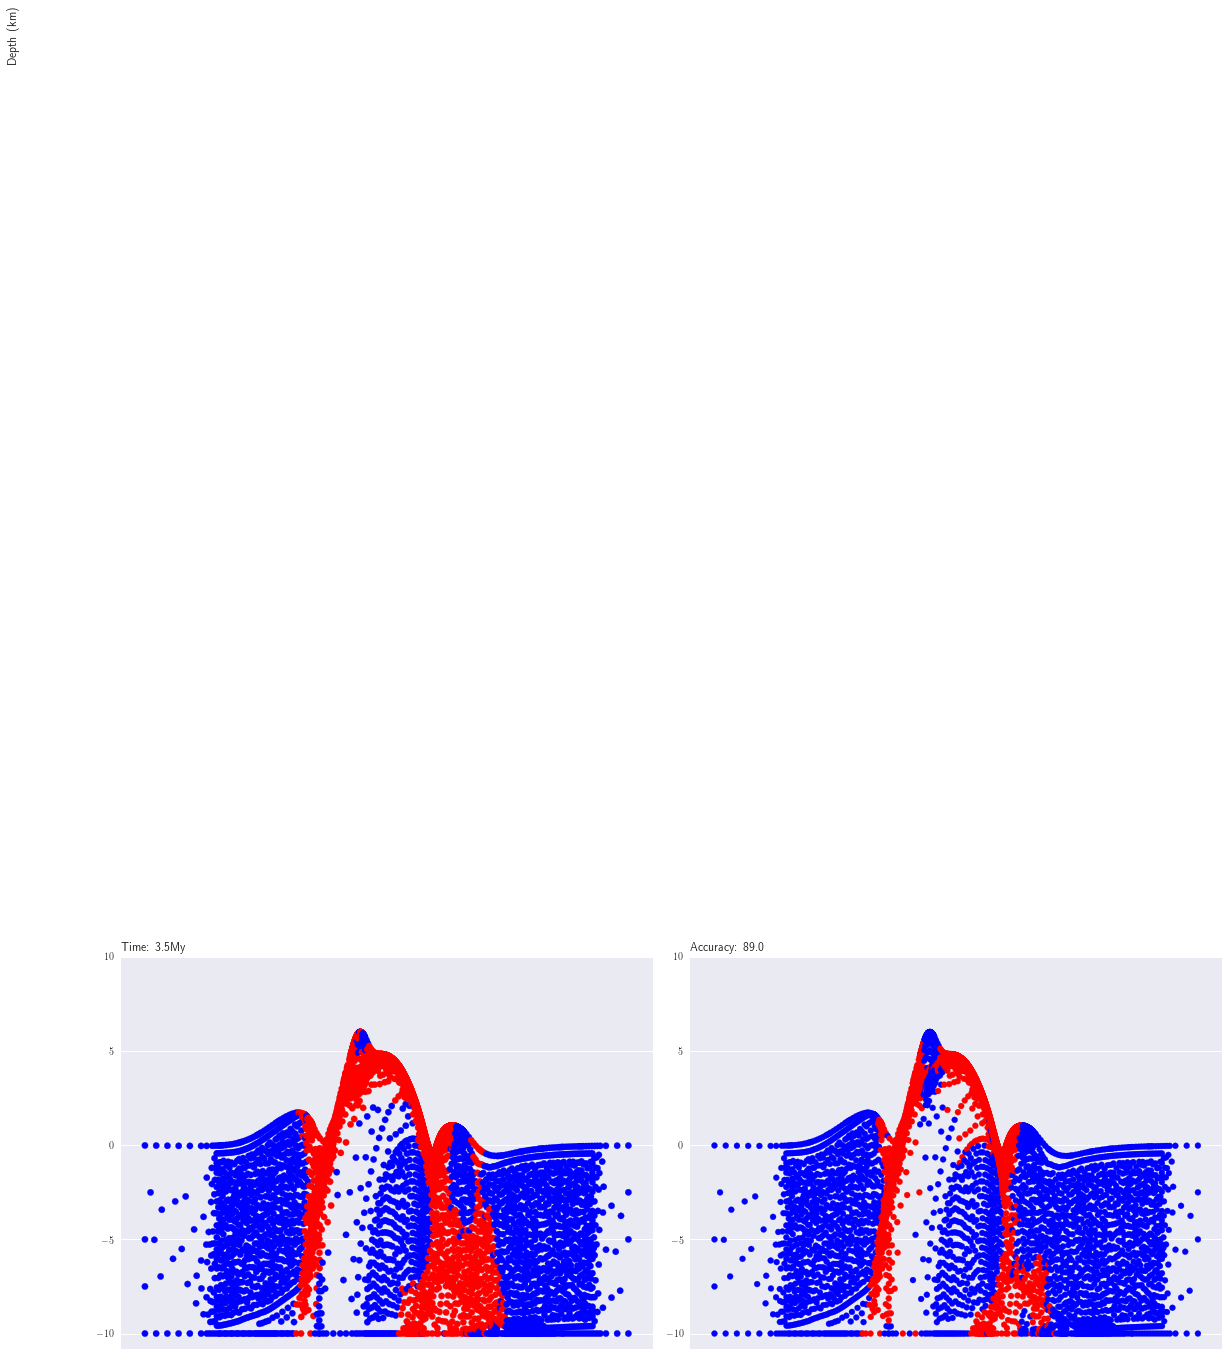

In [111]:
times = [350]
fig = plt.figure(figsize = (16,6))

for i, val  in enumerate(times):
    
#     file_name = "new_data/totoal."+ str(val) +".csv"
#     df_test = pd.read_csv(file_name)
#     df_test = df_test.drop_duplicates()
#     threshold = 0.15
#     df_test['plastic strain'] = np.where(df_test['plastic strain'] > threshold, 1,0)
#     xtest = df_test[feature_cols]
#     ytest = df_test['plastic strain']
#     scale = mms[0]
#     xtest = scale.fit_transform(xtest)
#     ypred = np.argmax(deviatoric.model.predict(xtest), axis = 1)
    acc = accuracy_score(ytest, newpred_test)
    
    ## Plot figure
    plt.subplot(1,2, (i+(i+1)))
    plt.scatter(x = df_test['coordinate:0']/1e3, y= df_test['coordinate:1']/1e3, 
                c = df_test['plastic strain'], vmin=0, vmax=1, s = 40 , cmap='bwr')
    plt.title('Time: ' + str(val/100.0)+'My', loc='left')
    plt.yticks([10, 5, 0, -5, -10])
    if (i+2) == 5:
        plt.xticks([-25, 0, 25, 50, 75, 100, 125])
        plt.xlabel('Distance (km)')
    else:
        plt.xticks([])
        
    
    plt.subplot(1,2,(i+(i+2)))
    plt.scatter(df_test['coordinate:0']/1e3, y= df_test['coordinate:1']/1e3,\
                c = newpred_test,\
                vmin = 0, vmax = 1, s = 35, cmap = 'bwr')
    
    plt.title('Accuracy: '+ str(round(acc, 2)*100) + '%', loc='left')
    plt.yticks([10, 5, 0, -5, -10])
    
    if (i+2) == 5:
        plt.xticks([-25, 0, 25, 50, 75, 100, 125])
        plt.xlabel('Distance (km)')
    else:
        plt.xticks([])
        
plt.text(-215, 60, 'Depth (km)', rotation=90)
plt.tight_layout()
fig.savefig('original_vs_predicted.png')
plt.show()

In [20]:
ytest = df_test['plastic strain']
print('Accuracy: {}\n'.format(accuracy_score(ytest, ypred)))
print('Classification report: \n {}\n'.format(classification_report(ytest, ypred)))
print('Confusion matrix: \n{}'.format(confusion_matrix(ytest, ypred)))

Accuracy: 0.9117996201329535

Classification report: 
              precision    recall  f1-score   support

          0       0.81      0.98      0.89      2963
          1       0.99      0.88      0.93      5461

avg / total       0.92      0.91      0.91      8424


Confusion matrix: 
[[2897   66]
 [ 677 4784]]


## Load model 

In [4]:
model = load_model('./weights/total_200.hdf5')

## Add application to real world

In [ ]:
app_feature_cols = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']